In [1]:
import keras
import keras.backend as K
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

Using TensorFlow backend.


In [2]:
content_img_path = 'imgs/chicago.jpg'
style_img_path = 'imgs/the_scream.jpg'

img_height = 400
img_width = 600
col_channels = 3

content_layer = 'block5_conv1'
style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

style_weight = 1. / len(style_layers)
content_weight = 0.025
iterations = 20

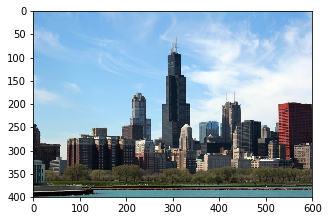

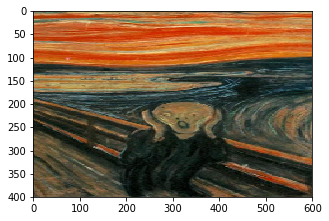

In [3]:
content_img = load_img(content_img_path, target_size=(img_height, img_width, col_channels))
style_img = load_img(style_img_path, target_size=(img_height, img_width, col_channels))

plt.figure(figsize=(5,5))
plt.imshow(content_img)
plt.figure(figsize=(5,5))
plt.imshow(style_img)

# Preprocess the image

In [4]:
def preprocess_image(img_path):
    x = load_img(img_path, target_size=(img_height, img_width, col_channels))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return x

# Deprocess image

In [5]:
def deprocess_image(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    
    # BGR to RBG
    x = x[:,:,::-1]
    
    # clip
    x = np.clip(x, 0,255).astype('uint8')
    
    return x

# Load the pretrained model and apply it to the content, style and generated image

In [6]:
content_image = K.variable(preprocess_image(content_img_path))
style_image = K.variable(preprocess_image(style_img_path))
generated_image = K.placeholder((1, img_height, img_width, col_channels))

# concatenate
input_tensor = K.concatenate([content_image, style_image, generated_image], axis=0)

# load the model
model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

# The content loss

In [7]:
def content_loss(content, generated):
    return K.sum(K.square(generated-content))

# The style loss

In [8]:
def gram_matrix(A):
    A = K.permute_dimensions(A, (2,1,0))
    A = K.batch_flatten(A)
    
    gram = K.dot(A, K.transpose(A))
    
    return gram

In [9]:
def style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    
    normaliz = 1./(4*(col_channels**2)*((img_height*img_width)**2))
    
    return normaliz*K.sum(K.square(S-G))

# The total loss

In [10]:
output_dict = dict([(layer.name, layer.output) for layer in model.layers])

loss = K.variable(0.)

# add the content loss
layer_features = output_dict[content_layer]
content_features = layer_features[0,:,:,:]
generated_features = layer_features[2,:,:,:]

loss += content_loss(content_features, generated_features)

# add the style loss
for layer_name in style_layers:
    layer_features = output_dict[layer_name]
    style_features = layer_features[1,:,:,:]
    generated_features = layer_features[2,:,:,:]
    
    ls = style_loss(style_features, generated_features)
    
    loss += style_weight*ls

# Setting up the gradient descent process

In [11]:
grads = K.gradients(loss, generated_image)[0]

fetch_grads_loss = K.function([generated_image],[loss, grads])


class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_value = None
        
    def loss(self, x):
        assert self.loss_value is None
        # ensure x has the good shape
        x = x.reshape((1, img_height, img_width, col_channels))
        
        outs = fetch_grads_loss([x])
        loss_value = outs[0]
        grads_value = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grads_value = grads_value
        
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grads_value = np.copy(self.grads_value)
        self.grads_value = None
        self.loss_value = None
        
        return grads_value
    
evaluator = Evaluator()

# The style transfer loop

In [13]:
x = preprocess_image(content_img_path)
x = x.flatten()

for i in range(iterations):
    print("Start iteration: ",i)
    
    start_time = time.time()
    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    
    img = x.copy().reshape((img_height, img_width, col_channels))
    img = deprocess_image(img)
    fname = 'my_img_iteration_%d.png' %i
    imsave(fname, img)
    
    
    
    end_time = time.time() - start_time
    
    print("End time: ",end_time)

Start iteration:  0


/home/merlin/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


End time:  8.563738822937012
Start iteration:  1
End time:  8.574847221374512
Start iteration:  2
End time:  8.53607439994812
Start iteration:  3
End time:  8.624275207519531
Start iteration:  4
End time:  8.754978895187378
Start iteration:  5
End time:  8.749250650405884
Start iteration:  6
End time:  8.724212408065796
Start iteration:  7
End time:  8.744156122207642
Start iteration:  8
End time:  8.77516770362854
Start iteration:  9
End time:  8.853216648101807
Start iteration:  10
End time:  9.382450103759766
Start iteration:  11
End time:  9.150343894958496
Start iteration:  12
End time:  8.778937816619873
Start iteration:  13
End time:  9.070995330810547
Start iteration:  14
End time:  8.943545579910278
Start iteration:  15
End time:  8.678084373474121
Start iteration:  16
End time:  8.862503290176392
Start iteration:  17
End time:  8.82236647605896
Start iteration:  18
End time:  8.864362955093384
Start iteration:  19
End time:  8.89664888381958
